### Two peak model precision comparison
This notebook takes 1900s in Analytic continuation.  
The broaden parameter $\eta$ is chosen to be smaller than all energy scales of the system.  
To try this notebook, please install the fllowing package
- Plots
- LaTexStrings
- SparseIR

In [1]:
using Plots
using LaTeXStrings
using LinearAlgebra
using SparseIR
using Nevanlinna

In [2]:
# Set work data Type
T = BigFloat
setprecision(128)
;

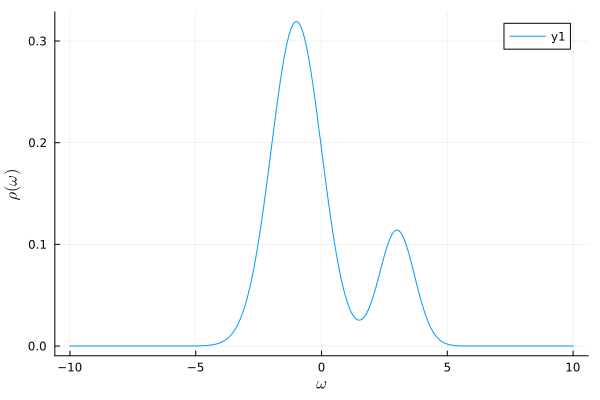

In [3]:
#define spectral function
gaussian(x, mu, sigma) = exp(-0.5*((x-mu)/sigma)^2)/(sqrt(2*π)*sigma)
rho(omega) = 0.8*gaussian(omega, -1.0, 1.0) + 0.2*gaussian(omega, 3, 0.7)
omegas = LinRange(-10, 10, 1000)
plot()
plot!(omegas, rho.(omegas), xlabel=latexstring("\\omega"), ylabel=latexstring("\\rho(\\omega)"))

In [4]:
function generate_input_data(rho::Function, beta::Float64)
    lambda = 1e+4
    wmax = lambda/beta
    basis = FiniteTempBasisSet(beta, wmax, 1e-15)

    rhol = [overlap(basis.basis_f.v[l], rho) for l in 1:length(basis.basis_f)]
    gl = - basis.basis_f.s .* rhol
    gw = evaluate(basis.smpl_wn_f, gl)
    
    hnw = length(basis.smpl_wn_f.sampling_points)÷2
    
    input_smpl = Array{Complex{T}}(undef, hnw) 
    input_gw   = Array{Complex{T}}(undef, hnw) 
    
    for i in 1:hnw
        input_smpl[i]= SparseIR.valueim(basis.smpl_wn_f.sampling_points[hnw+i], beta)
        input_gw[i]  = gw[hnw+i]
    end
    
    return input_smpl, input_gw
end

generate_input_data (generic function with 1 method)

In [5]:
beta = 100. #inverse temperature
input_smpl, input_gw = generate_input_data(rho, beta)
;

In [6]:
f64_input_smpl = ComplexF64.(input_smpl)
f64_input_gw   = ComplexF64.(input_gw)
;

In [7]:
N_real    = 1000  #demension of array of output
omega_max = 10.0  #energy cutoff of real axis
eta       = 0.001 #broaden parameter 
sum_rule  = 1.0   #sum rule
H_max     = 50    #cutoff of Hardy basis
lambda    = 1e-4  #regularization parameter
iter_tol  = 1000  #upper bound of iteration
;

In [8]:
#construct solver struct
@time sol     = Nevanlinna.NevanlinnaSolver(input_smpl, input_gw, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, verbose=false)
@time f64_sol = Nevanlinna.NevanlinnaSolver(f64_input_smpl, f64_input_gw, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, verbose=false)
;

 26.033510 seconds (94.07 M allocations: 4.397 GiB, 6.32% gc time, 83.90% compilation time)
 13.167433 seconds (13.98 M allocations: 952.615 MiB, 4.90% gc time, 99.38% compilation time)


In [9]:
#execute optimize
@time Nevanlinna.solve!(sol)
@time Nevanlinna.solve!(f64_sol)
;

1854.650555 seconds (33.34 G allocations: 1.360 TiB, 18.12% gc time, 0.00% compilation time: 100% of which was recompilation)
  5.715234 seconds (2.17 M allocations: 10.674 GiB, 13.22% gc time, 0.26% compilation time)


In [10]:
wo_sol = NevanlinnaSolver(input_smpl, input_gw, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, verbose=true, optimization=false)
f64_wo_sol = Nevanlinna.NevanlinnaSolver(f64_input_smpl, f64_input_gw, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, verbose=true, optimization=false)
;

N_imag is setted as 31
N_imag is setted as 15


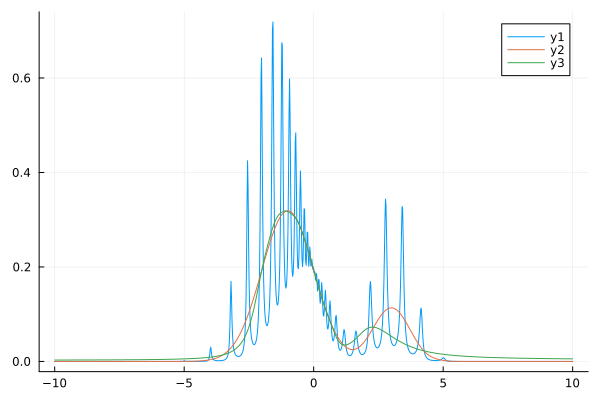

In [11]:
plot()
plot!(real.(wo_sol.reals.freq), imag.(wo_sol.reals.val)/pi)
#plot!(real.(f64_wo_sol.reals.freq), imag.(f64_wo_sol.reals.val)/pi)
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val))/pi)
plot!(Float64.(real.((f64_sol.reals.freq))), Float64.(imag.(f64_sol.reals.val))/pi)
#plot!(omegas, rho.(omegas))
#savefig("picture.png")

In [12]:
plot(xlim = [-6,6],
    size = (540,400),
    legend = :topright,
    xticks = [5,0,-5],
    legendfont=font(12, "Times"),
    guidefont=font(22), 
    xtickfont=font(15, "Times"), 
    ytickfont=font(15, "Times"), 
    ylabel=latexstring("\\rho(\\omega)"),
    xlabel=latexstring("\\omega"),
    framestyle=:box,
)
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val)/pi),label="opt 128bit",lw=5)
plot!(Float64.(real.((f64_sol.reals.freq))), Float64.(imag.(f64_sol.reals.val)/pi),label="opt 64bit",lw=5)
plot!(omegas, rho.(omegas), label="exact",lw=2.5, ls=:dash,lc=:black)

savefig("data/two_peak_presicion.svg")

"/home/kosuke/work/Nevanlinna.jl/notebooks/data/two_peak_presicion.svg"